# Урок 5. Случайный лес

### 1) Формирования выборки - bootstrap
![img/bootstrap.jpg](img/bootstrap.jpg)


### 2) Построение композиции алгоритмов - bagging
![img/bagging.png](img/bagging.png)  


### Random Forest == bagging на решающих деревьях

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

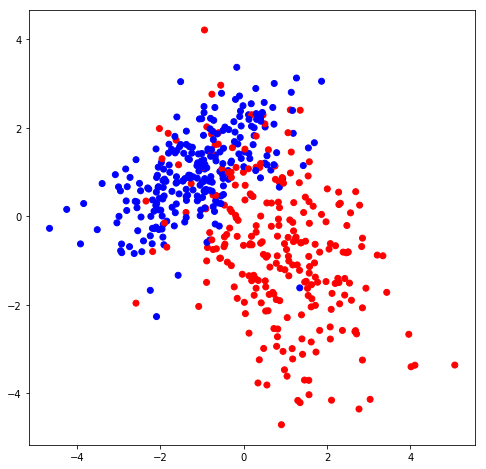

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

Повторим реализацию построения дерева решений из предыдущего урока

In [4]:
# Реализуем класс узла

class Node:

    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [6]:
random.seed(42)

def get_bootstrap(data, labels, N):
       
    n_samples = data.shape[0]
    bootstrap = []

    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)

        # TODO: random.choice()
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))

    return bootstrap

In [7]:
def get_subsample(len_sample):
    
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for i in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf=1):
    
    #  обозначим минимальное количество объектов в узле
#     min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels, min_leaf=1)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [13]:
def random_forest(data, labels, n_trees):
    
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [14]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

### Предсказание голосованием деревьев

In [16]:
def tree_vote(forest, data):
    
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
        
    predictions_per_object = list(zip(*predictions))
    
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
    
    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее.

In [17]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Тест самописного случайного леса

In [19]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

Wall time: 397 ms


In [20]:
train_answs = tree_vote(my_forest_1, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 1 деревьев на train: 93.143


In [21]:
test_answs = tree_vote(my_forest_1, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 1 деревьев на test: 93.333


In [22]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

Wall time: 894 ms


In [23]:
train_answs = tree_vote(my_forest_3, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 3 деревьев на train: 97.429


In [24]:
test_answs = tree_vote(my_forest_3, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 3 деревьев на test: 96.000


In [25]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

Wall time: 3.25 s


In [26]:
train_answs = tree_vote(my_forest_10, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 10 деревьев на train: 99.143


In [27]:
test_answs = tree_vote(my_forest_10, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 10 деревьев на test: 96.667


In [28]:
%%time
n_trees = 30
my_forest_30 = random_forest(train_data, train_labels, n_trees)

Wall time: 9.6 s


In [29]:
train_answs = tree_vote(my_forest_30, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 30 деревьев на train: 99.714


In [30]:
test_answs = tree_vote(my_forest_30, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 30 деревьев на test: 95.333


In [31]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

Wall time: 15.3 s


In [32]:
train_answs = tree_vote(my_forest_50, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 50 деревьев на train: 100.000


In [33]:
test_answs = tree_vote(my_forest_50, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 50 деревьев на test: 96.000


### Домашнее задание  
1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать  
 их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).  
   Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем (*).  
2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.  
3. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy (*).  

#### 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем (*).

In [34]:
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

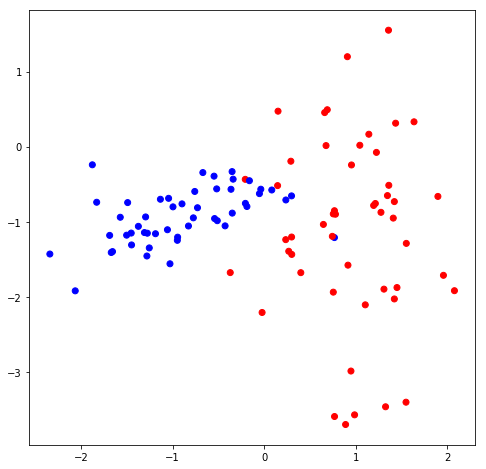

In [35]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [36]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 67)

In [37]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

Wall time: 10 ms


In [38]:
train_answs = tree_vote(my_forest_1, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 1 деревьев на train: 95.714


In [39]:
test_answs = tree_vote(my_forest_1, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 1 деревьев на test: 93.333


Text(0.5,1,'Test accuracy=93.33')

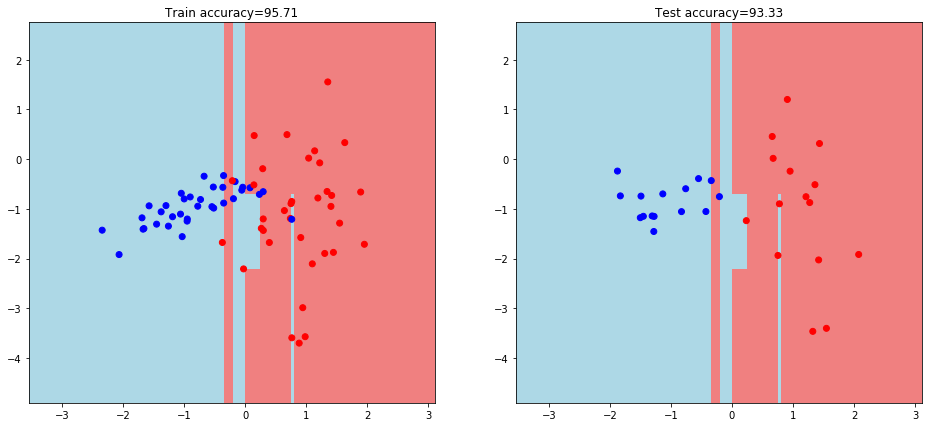

In [40]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

In [41]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

Wall time: 32 ms


In [42]:
train_answs = tree_vote(my_forest_3, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 3 деревьев на train: 97.143


In [43]:
test_answs = tree_vote(my_forest_3, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 3 деревьев на test: 93.333


Text(0.5,1,'Test accuracy=93.33')

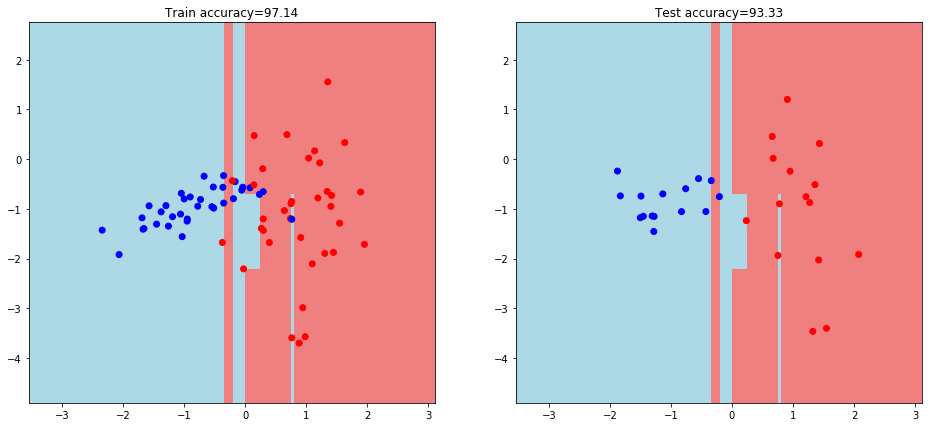

In [44]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

In [47]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

Wall time: 99.1 ms


In [48]:
train_answs = tree_vote(my_forest_10, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 10 деревьев на train: 98.571


In [49]:
test_answs = tree_vote(my_forest_10, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 10 деревьев на test: 96.667


Text(0.5,1,'Test accuracy=96.67')

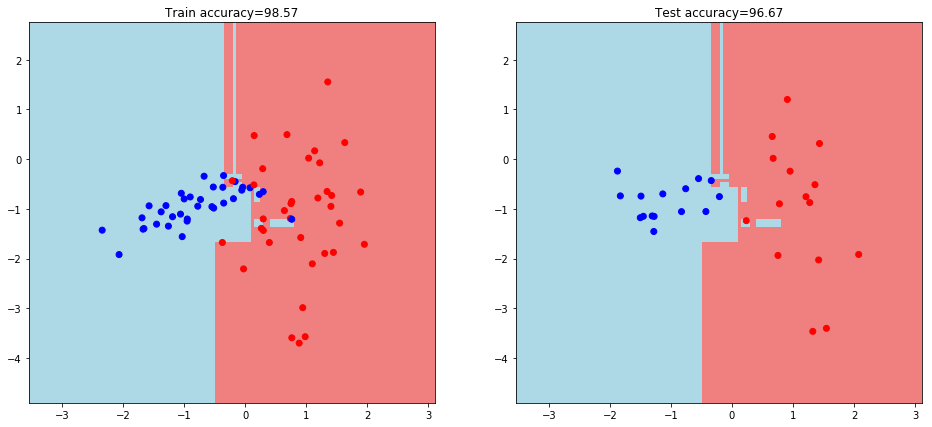

In [50]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

In [52]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

Wall time: 490 ms


In [53]:
train_answs = tree_vote(my_forest_50, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 50 деревьев на train: 100.000


In [54]:
test_answs = tree_vote(my_forest_50, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 50 деревьев на test: 96.667


Text(0.5,1,'Test accuracy=96.67')

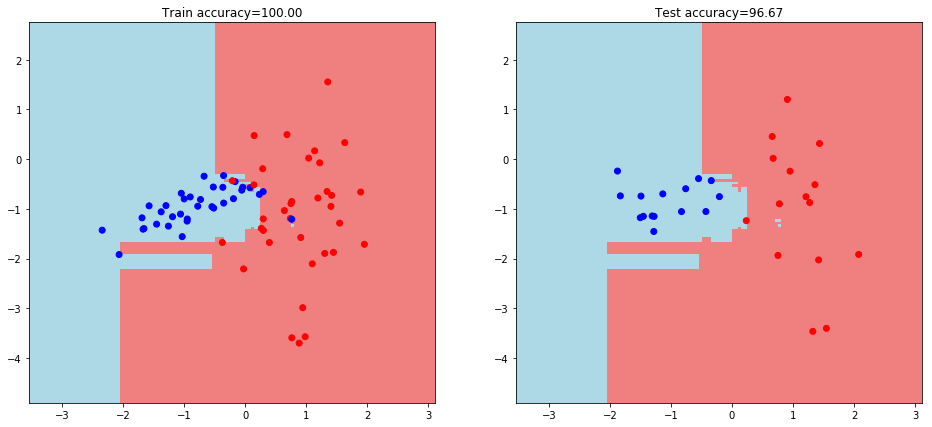

In [55]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

Полученная плоскость, на мой взгляд, среднеей сложности. Она не примитивна, имеет некоторые фигурные особенности. Test accuracy здесь одинаковый как при лесе в 10 деревьев, так и при лесе в 50 деревьев и больше не растет, значит 10 деревьев достаточное количество для этого случая. При лесе в 50 деревьев не наступило переобучение, поскольку метрика не упала, а осталась прежней. Accuracy = 96.67 - довольно не плохой результат.
Из любопытства посмотрим, что будет при размере леса в 100 деревьев.

In [57]:
%%time
n_trees = 100
my_forest_100 = random_forest(train_data, train_labels, n_trees)

Wall time: 957 ms


In [58]:
train_answs = tree_vote(my_forest_100, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 100 деревьев на train: 100.000


In [59]:
test_answs = tree_vote(my_forest_100, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 100 деревьев на test: 96.667


Text(0.5,1,'Test accuracy=96.67')

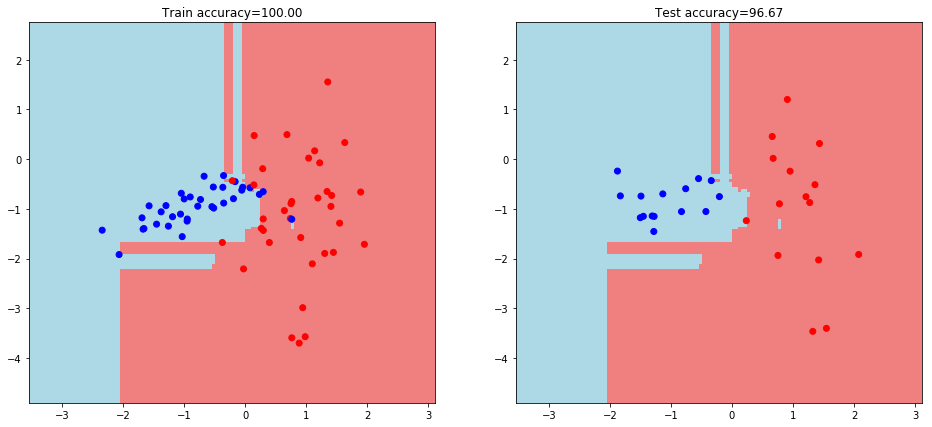

In [60]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_100, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

Как видно, здесь все без именений, поэтому вполне можно было остановиться на 10 деревьях.

#### 2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [ ]:
def out_of_bag()

#### 3.(На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy (*)

In [61]:
import math

def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    entropy = 0
    for label in classes:
        p = classes[label] / len(labels)
        entropy -= p * math.log2(p)
        
    return entropy

In [62]:
calc_entropy(classification_labels)

1.0

Классы в выборке у нас сбалансированы, поэтому и энтропия максимальная. 